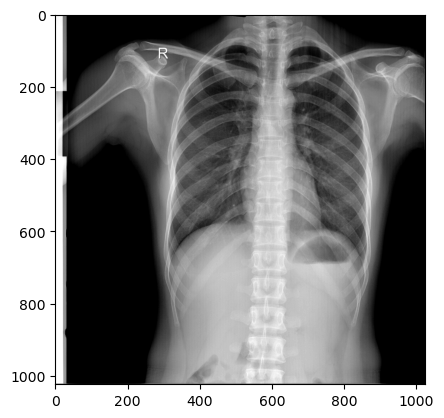

In [1]:
##### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# !pip install torcheval --quiet
# !pip install torchxrayvision --quiet
# !pip install pycocotools --quiet
# !pip install grad-cam --quiet

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import torch 
import torchvision
import cv2
import matplotlib.pyplot as plt
import warnings
import gc, copy
torch.cuda.empty_cache()
gc.collect()

root_path = Path("../data/amia-public-challenge-2024")
img = cv2.imread(str(root_path / "train/train/00JgsY3R0C6VQrT7VDFcoqW2J7dOfULr.png"), 0)
img
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from scipy import stats 
stats.describe(img.flatten())

DescribeResult(nobs=1048576, minmax=(0, 255), mean=93.09384727478027, variance=5716.175982514438, skewness=0.19330046353736843, kurtosis=-1.1984942683938915)

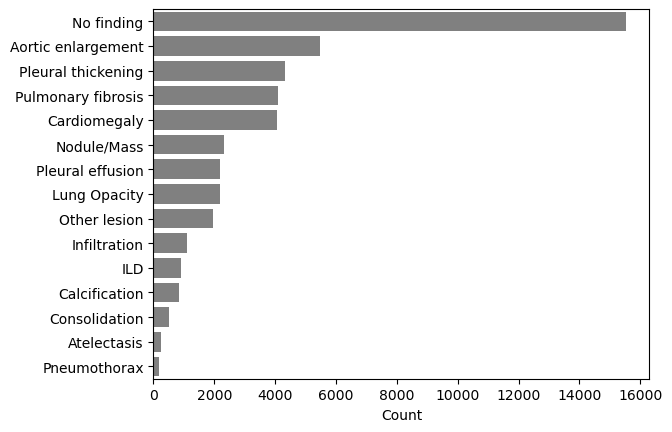

In [3]:
# Class imbalance? 
import pandas as pd
import seaborn as sns

df = pd.read_csv(root_path / "train.csv")
counts = df['class_name'].value_counts()

sns.barplot(y=counts.index, x=counts.values, color="gray")
plt.xlabel("Count")
plt.ylabel("")
plt.show()

Bounding box width statistics:
Mean: 76.82, Std: 58.50, Min: 1.75, Max: 428.83

Bounding box height statistics:
Mean: 61.45, Std: 51.66, Min: 0.44, Max: 439.21


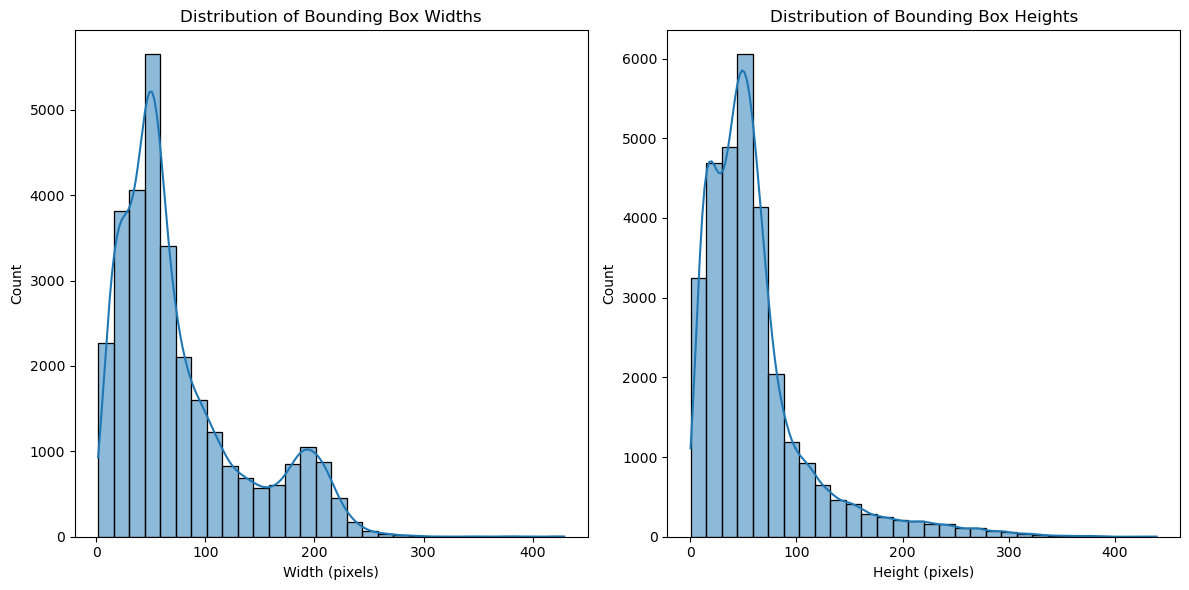

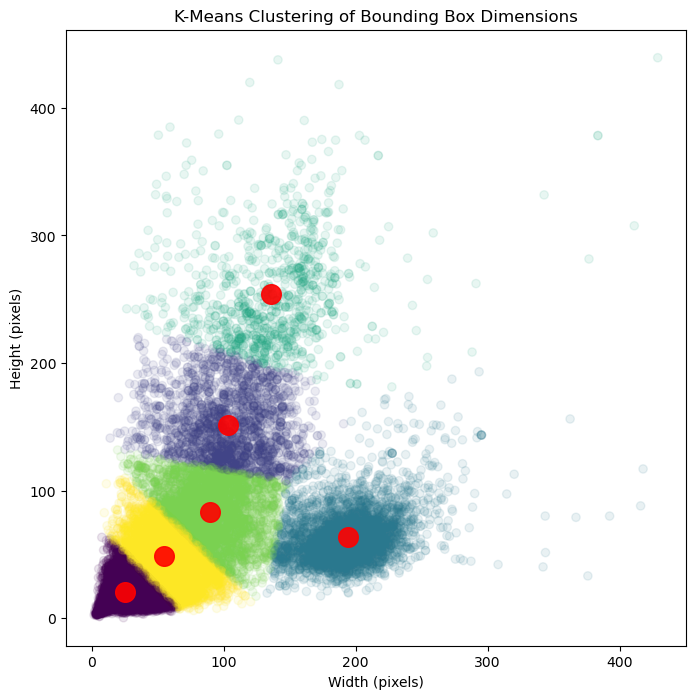

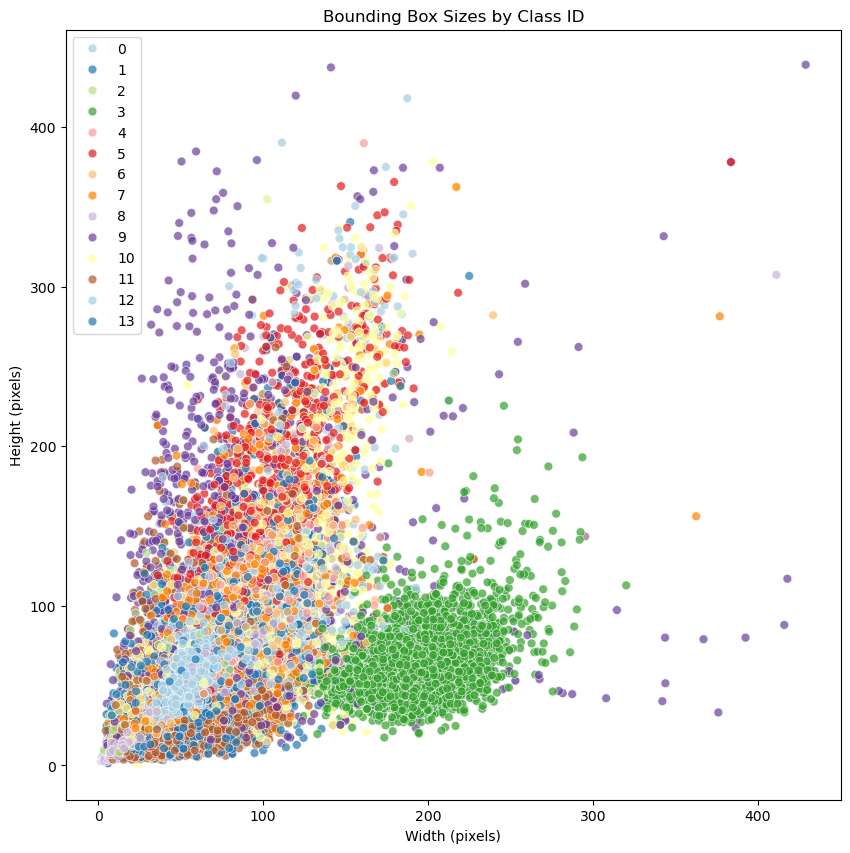


Suggested anchor sizes (width x height):
25 x 20
103 x 151
194 x 63
135 x 254
89 x 83
54 x 48

Aspect ratios:
[0.821158191213415, 1.4690661767342945, 0.3286102713482433, 1.8698965582724687, 0.924602923280782, 0.8842621378582614]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 


# Load the CSV file
dict_path = "pre-pro/image_dict.json"

with open(dict_path) as f:
    data = json.load(f)

box_widths = []
box_heights = []
class_ids = []
# Iterate over each image in the dictionary
for image_id, image_data in data.items():
    original_width, original_height = image_data["og_dims"]

    # Iterate over each class
    for class_id, radiologists in image_data["classes"].items():
        if class_id == "14":  # ignore no findings
            continue
        # Iterate over each radiologist's annotations
        for rad_id, boxes in radiologists.items():
            for box in boxes:
                x_min, y_min, x_max, y_max = box

                # Convert relative coordinates to absolute pixel values
                box_width = (x_max - x_min) * 448  # targeted image size for training
                box_height = (y_max - y_min) * 448

                # Append the width and height to the respective lists
                box_widths.append(box_width)
                box_heights.append(box_height)
                class_ids.append(int(class_id))

box_widths = np.array(box_widths)
box_heights = np.array(box_heights)
class_ids = np.array(class_ids)

# Print basic statistics
print("Bounding box width statistics:")
print(f"Mean: {box_widths.mean():.2f}, Std: {box_widths.std():.2f}, Min: {box_widths.min():.2f}, Max: {box_widths.max():.2f}")

print("\nBounding box height statistics:")
print(f"Mean: {box_heights.mean():.2f}, Std: {box_heights.std():.2f}, Min: {box_heights.min():.2f}, Max: {box_heights.max():.2f}")

# Plot the distribution of box sizes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(box_widths, bins=30, kde=True)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width (pixels)')

plt.subplot(1, 2, 2)
sns.histplot(box_heights, bins=30, kde=True)
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height (pixels)')

plt.tight_layout()
plt.show()

# Calculate anchor box suggestions using k-means clustering
from sklearn.cluster import KMeans
box_dimensions = np.column_stack((box_widths, box_heights))
num_anchors = 6  # Number of anchors to suggest
kmeans = KMeans(n_clusters=num_anchors, random_state=0).fit(box_dimensions)

# plot the clusters
plt.figure(figsize=(8, 8))
plt.scatter(box_widths, box_heights, c=kmeans.labels_, cmap="viridis", alpha=0.1)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c="red", s=200, alpha=0.9)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("K-Means Clustering of Bounding Box Dimensions")
plt.show()


plt.figure(figsize=(10, 10))
sns.scatterplot(x=box_widths, y=box_heights, hue=class_ids, 
                palette="Paired", alpha=0.7, s=40)
plt.title("Bounding Box Sizes by Class ID")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()



# Output the cluster centers as suggested anchor sizes
print("\nSuggested anchor sizes (width x height):")
for anchor_size in kmeans.cluster_centers_:
    print(f"{int(anchor_size[0])} x {int(anchor_size[1])}")
print("\nAspect ratios:") 
print([height/width for width, height in kmeans.cluster_centers_])

In [5]:
import torch
from torch import Tensor
from typing import List

def calculate_scales(widths: List[float], heights: List[float], aspect_ratios: List[float]) -> List[float]:
    """
    Calculate the scales needed for the generate_anchors function given desired widths, heights, and aspect ratios.

    Args:
        widths (List[float]): Desired widths of the anchors.
        heights (List[float]): Desired heights of the anchors.
        aspect_ratios (List[float]): Aspect ratios (height/width) corresponding to each anchor.

    Returns:
        List[float]: Calculated scales that can be used in the generate_anchors function.
    """
    scales = []
    for width, height, aspect_ratio in zip(widths, heights, aspect_ratios):
        # Calculate the scale based on the width and aspect ratio
        scale = width * torch.sqrt(torch.tensor(aspect_ratio))
        scales.append(scale.item())
    return scales


ratios = [height/width for width, height in kmeans.cluster_centers_]
widths = [x for x, _ in kmeans.cluster_centers_]
heights = [y for _, y in kmeans.cluster_centers_]
sizes = calculate_scales(widths, heights, ratios)
print("widths:",widths)
print("heights:",heights)
print("ratios:",ratios)
print("sizes:",sizes) # -> one size is '111'. test below v



# This is the pytorch function from anchors_utils.py to check if a correct box would be generated :) 
def generate_anchors(
    scales: List[int],
    aspect_ratios: List[float],
    dtype: torch.dtype = torch.float32,
    device: torch.device = torch.device("cpu"),
) -> Tensor:
    scales = torch.as_tensor(scales, dtype=dtype, device=device)
    aspect_ratios = torch.as_tensor(aspect_ratios, dtype=dtype, device=device)
    h_ratios = torch.sqrt(aspect_ratios)
    w_ratios = 1 / h_ratios

    ws = (w_ratios[:, None] * scales[None, :]).view(-1)
    hs = (h_ratios[:, None] * scales[None, :]).view(-1)

    base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
    return base_anchors.round()

print("\nAnchors:\n",generate_anchors([111], [ratios[0]]))



widths: [25.295237945546454, 103.0872928720659, 194.52595336463756, 135.96673243527394, 89.8717785159817, 54.863213473992936]
heights: [20.771391837677868, 151.44205520945434, 63.92322631942926, 254.24372502027236, 83.09570913631966, 48.51346243628716]
ratios: [0.821158191213415, 1.4690661767342945, 0.3286102713482433, 1.8698965582724687, 0.924602923280782, 0.8842621378582614]
sizes: [22.92198287658036, 124.94699475587475, 111.51110501618423, 185.92656758295394, 86.41735454830678, 51.59073992495707]

Anchors:
 tensor([[-61., -50.,  61.,  50.]])


In [12]:
import os
import numpy as np
import time
from tqdm.autonotebook import tqdm as tqdm
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms, tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2
import torchxrayvision as xrv

# import medmnist
# from medmnist import ChestMNIST, DermaMNIST, INFO, Evaluator
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torch.optim import lr_scheduler, SGD
from tqdm.autonotebook import tqdm
from torcheval.metrics.functional import multiclass_confusion_matrix
from torchinfo import summary
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import json

import torch.nn.functional as F
from torchvision.transforms.v2 import functional as F2
import torch.utils.data as data
import torchvision.transforms as transforms

import torch.optim as optim


import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN, rpn
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import get_cmap

from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

import random, warnings


# --------------- Constants ------------------

ROOT = str(root_path)
# call augment data function
pic_folder_path = ROOT + "/train/train"
inf_folder_path = ROOT + "/test/test"
dict_path = dict_path
batch_size = 10

class_names = {
    0: "Aortic enlargement",
    1: "Atelectasis",
    2: "Calcification",
    3: "Cardiomegaly",
    4: "Consolidation",
    5: "ILD",
    6: "Infiltration",
    7: "Lung Opacity",
    8: "Nodule/Mass",
    9: "Other lesion",
    10: "Pleural effusion",
    11: "Pleural thickening",
    12: "Pneumothorax",
    13: "Pulmonary fibrosis",
    14: "No finding",
}

label_mapping = {
    "14": 0,  # 'No finding' mapped to 0 (background class)
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5,
    "5": 6,
    "6": 7,
    "7": 8,
    "8": 9,
    "9": 10,
    "10": 11,
    "11": 12,
    "12": 13,
    "13": 14,
}


# Detect OS and set num_workers accordingly
if os.name == "nt":  # Windows
    num_workers = 0
else:  # Linux and others
    num_workers = 2


# --------------- Helper functions ------------------
# Custom collate function to handle varying sizes of bounding boxes
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, targets


def get_device():
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        warnings.warn("CUDA not available. Using CPU instead.", UserWarning)
    print("Device set to {}.".format(device))
    return device


# set seeds for reproducibility
def set_seeds(seed=123420):
    random.seed(seed)
    np.random.seed(seed + 1)
    torch.random.manual_seed(seed + 2)
    device = get_device()
    if device == "cuda":
        torch.cuda.manual_seed(seed + 3)
        torch.cuda.manual_seed_all(seed + 4)
        torch.backends.cudnn.deterministic = True
    print("Seeds set to {}.".format(seed))
    return


def string_to_tensor(s):
    return torch.tensor([ord(c) for c in s], dtype=torch.int64)


def tensor_to_string(t):
    return "".join([chr(c) for c in t])


class GrayscaleImageListDataset(Dataset):
    def __init__(self, img_dir, img_list, transform=None):
        self.img_dir = img_dir
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image


def get_mean_and_std(
    img_dir, img_list, batch_size=32, print_values=False, leave_pbar=False
):
    """
    Compute the mean and std color values of all images (grayscale values) in the specified list.

    Parameters:
    - img_dir (str): Directory containing the images.
    - img_list (list): List of image filenames to include in the calculation.
    - batch_size (int): Batch size for processing images.
    - print_values (bool): Whether to print the mean and std values.
    - leave_pbar (bool): Whether to leave the progress bar after completion.

    Returns:
    - mean (torch.Tensor): Mean grayscale values.
    - std (torch.Tensor): Standard deviation of grayscale values.
    """
    device = get_device()
    transform = v2.ToDtype(torch.float32, scale=True)
    dataset = GrayscaleImageListDataset(img_dir, img_list, transform=transform)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
    )

    channels_sum = torch.zeros(1).to(device)
    channels_squared_sum = torch.zeros(1).to(device)
    num_pixels = 0
    
    for images in tqdm(
        dataloader,
        desc="Calculating mean and std of all grayscale values",
        leave=leave_pbar,
        colour="CYAN",
    ):
        images = images.to(device)
        non_black_pixels = images[images != 0].view(-1)
        num_pixels += non_black_pixels.shape[0]

        channels_sum += torch.sum(non_black_pixels)
        channels_squared_sum += torch.sum(non_black_pixels**2)

    mean = channels_sum / num_pixels
    std = (channels_squared_sum / num_pixels - mean**2) ** 0.5

    if print_values:
        print(
            "Mean: ", mean.cpu().detach().numpy(), ", Std: ", std.cpu().detach().numpy()
        )

    return mean, std

# --------------- Data Loader ------------------
class XRayImageDataset(Dataset):
    """
    load image and targets from dict
    structure of the dict
        img_id: {
            "classes": [
                class_id: [
                rad_id: [[bbox],[bbox]]]
    """

    def __init__(
        self,
        dict,
        img_size,
        img_dir,
        mean=None,
        std=None,
        transform_norm=None,
        nms=True,
        nms_iou_thresh=0.5,
        device=None,
    ):
        self.dict = dict
        self.keys = list(dict.keys())
        self.img_size = img_size
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform_norm = transform_norm
        self.nms = nms
        self.nms_iou_thresh = nms_iou_thresh
        if device is None:
            self.device = get_device()
        else:
            self.device = "cpu"

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        img_id = self.keys[idx]
        img_path = os.path.join(self.img_dir, img_id) + ".png"

        image = read_image(img_path)

        box_list = []
        label_list = []
        area_list = []
        iscrowd_list = []
        for class_id in self.dict[img_id]["classes"]:
            if class_id == "14":
                continue
            # collect all boxes for the current class
            box = []
            for rad in self.dict[img_id]["classes"][class_id].items():
                for box in rad[1]:
                    # Ensure the box has 4 coordinates
                    if len(box) == 4 and box[2] > box[0] and box[3] > box[1]:
                        box_list.append([coord * image.shape[-1] for coord in box])
                        label_list.append(label_mapping[class_id])
                        area_list.append((box[2] - box[0]) * (box[3] - box[1]))
                        iscrowd_list.append(0)
                    else:
                        print(f"Invalid Box found at {img_id} with {box}")
            if self.nms:
                # Non-maximum suppression
                boxes_to_keep = torchvision.ops.nms(
                    torch.tensor(box_list).float(),
                    torch.tensor([1.0] * len(box_list)),
                    iou_threshold=self.nms_iou_thresh,
                )
                # now keep only the values of the indices that are in boxes_to_keep
                box_list = [box_list[i] for i in boxes_to_keep]
                label_list = [label_list[i] for i in boxes_to_keep]
                area_list = [area_list[i] for i in boxes_to_keep]
                iscrowd_list = [iscrowd_list[i] for i in boxes_to_keep]

        if len(box_list) > 0:
            boxes_tensor = tv_tensors.BoundingBoxes(
                box_list, format="XYXY", canvas_size=(image.shape[-1], image.shape[-1])
            )
        else:
            empty_boxes = np.array([]).reshape(-1, 4)
            boxes_tensor = torch.as_tensor(empty_boxes, dtype=torch.int16)
        labels_tensor = torch.tensor(label_list, dtype=torch.int64)
        areas_tensor = torch.tensor(area_list, dtype=torch.int32)
        iscrowd_tensor = torch.tensor(iscrowd_list, dtype=torch.uint8)

        if self.transform_norm:
            image, boxes_tensor = self.transform_norm(image.to(device=self.device), boxes_tensor.to(device=self.device))

        target = {
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "area": areas_tensor,
            "iscrowd": iscrowd_tensor,
            "filename": string_to_tensor(img_id),
        }

        return image, target

class XRayInferenceDataset(Dataset):
    """
    Dataset for X-ray images, focusing on inference.
    It loads only the image and the filename.
    """

    def __init__(self, img_dir, transform=None):
        """
        Args:
            img_dir (str or Path): Directory where the images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = Path(img_dir)
        self.file_list = [p.stem for p in self.img_dir.glob("*.png")]
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_id = self.file_list[idx]
        img_path = self.img_dir / f"{img_id}.png"

        image = read_image(str(img_path))

        if self.transform:
            image = self.transform(image)

        return image, img_id

def load_and_augment_images(
    pic_folder_path,
    inf_folder_path,
    dict_path,
    batch_size,
    class_names,
    img_size=448,
    use_normalize=False,
):
    # split folders into 70% train and 30% test by ids
    set_seeds()
    train_percent = 0.8
    # Use the images in the ONE folder and split them into train and test
    train_ids = random.sample(
        os.listdir(pic_folder_path),
        int(train_percent * len(os.listdir(pic_folder_path))),
    )
    test_ids = [id for id in os.listdir(pic_folder_path) if id not in train_ids]

    # normalize on all train images or use precomputed
    if use_normalize:
        mean, std = get_mean_and_std(
            pic_folder_path, train_ids, print_values=True, leave_pbar=True
        )
        print("Mean: ", mean, ", Std: ", std)
    else:
        mean = 0.57062465
        std = 0.24919559

    # remove file extension
    train_ids = [id.split(".")[0] for id in train_ids]
    test_ids = [id.split(".")[0] for id in test_ids]
    # print first values and lengths
    print(f"Length of train_ids: {len(train_ids)}")
    print(f"Length of test_ids: {len(test_ids)}")

    # Data augmentation and normalization for training1
    data_transforms = {
        "train": v2.Compose(
            [
                #v2.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
                v2.Resize(img_size, antialias=True),
                v2.RandomRotation(
                    degrees=(-6, 6)
                ),  # all images are upright and will always be. No rotation needed? COuld be interesting to try for generalizing
                v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0),
                v2.RandomPerspective(distortion_scale=0.1, p=0.1),
                #v2.RandomEqualize(p=1.),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[mean], std=[std], inplace=True), # maybe exclude, since retinanet expects values between 0-1
            ]
        ),
        "test": v2.Compose(
            [
                v2.ToTensor(),
                v2.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
                v2.Resize(img_size, antialias=True),
                v2.ToDtype(torch.uint8, scale=True),
                # Equalize all images to have a more uniform distribution of pixel intensities, regardless of they are generally dark or light
                #v2.RandomEqualize(p=1.),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[mean], std=[std], inplace=True),
            ]
        ),
    }

    # load image_dict.json
    with open(dict_path) as f:
        og_dict = json.load(f)

    # train_dict where keys match train_ids
    train_dict = {
        k: og_dict[k] for k in train_ids}# if "14" not in og_dict[k]["classes"]}
    #print("Remaining train dict length: ", len(train_dict))
    test_dict = {
        k: og_dict[k] for k in test_ids}# if "14" not in og_dict[k]["classes"]}
    #print("Remaining test dict length: ", len(test_dict))

    # size for images
    img_size = img_size
    train_dataset = XRayImageDataset(
        train_dict, img_size, pic_folder_path, mean, std, data_transforms["train"]
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    test_dataset = XRayImageDataset(
        test_dict, img_size, pic_folder_path, mean, std, data_transforms["test"]
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  # no need for batches
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    # image folder
    inference_dataset = XRayInferenceDataset(
        inf_folder_path, transform=data_transforms["test"]
    )

    inference_dataloader = torch.utils.data.DataLoader(
        inference_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    print("Loaded the training dataset.")

    dataloaders = {"train": train_dataloader, "test": test_dataloader, "inference": inference_dataloader}

    num_classes = class_names.items().__len__()

    return dataloaders, class_names, num_classes


# --------------- Model ------------------

# this nacho generator workes great so far, but we can do better: 
#anchor_generator = rpn.AnchorGenerator(
#   sizes=((10,), (60,), (200,))*5, # times 5 'cause we want all sizes on all layers 
#   aspect_ratios=((0.3, 1.0, 1.5),)*5, # times 5 'cause 5 feature maps'
#)

# considering the bboxes of the k-means analysis, we chose the following anchors at each level. We rounded up to arbitrary values to end up a bit more in the upper right of each cluster. 
# two cluster sizes were combined
anchor_generator = rpn.AnchorGenerator(
   sizes=((30,), (60,), (130,), (200,))*5, # times 5 'cause we want all sizes on all layers
   aspect_ratios=((0.32, 1., 1.8,),)*5, # times 5 'cause 5 feature maps'
)


#model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT", trainable_backbone_layers=5)

# use pre-trained on chest x-rays
backbone = xrv.models.ResNet(weights="resnet50-res512-all")
backbone = torch.nn.Sequential(*list(backbone.model.children())[:-2])

def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

# Define the layers to return feature maps from
return_layers = {
    '4': '0',  # Corresponds to layer1
    '5': '1',  # Corresponds to layer2
    '6': '2',  # Corresponds to layer3
    '7': '3',  # Corresponds to layer4
    # TODO where is number '4'? roi_align has #5 feature maps
}

# Construct the BackboneWithFPN
backbone_with_fpn = BackboneWithFPN(
    backbone,
    return_layers=return_layers,  # The layers we want to use
    in_channels_list=[256, 512, 1024, 2048],  # Corresponding in_channels for these layers
    out_channels=256  # Out channels for FPN layers
)

roi_align = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3', '4'], output_size=7, sampling_ratio=2)

model = torchvision.models.detection.FasterRCNN(
    backbone_with_fpn,
    num_classes=15,
    #min_size=448, # produces NaN losses
    #max_size=448,
    #image_mean=[0.57062465], # TODO: to prevent ImageNet normalizing, we can change this to m=0, s=1 and rely on our own normalization :) 
    #image_std=[0.24919559], 
    image_mean=[0],
    image_std=[1],
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_align,
    #box_batch_size_per_image=128,
    #rpn_pre_nms_top_n_train=2000,
    #rpn_post_nms_top_n_test=1000,
    #rpn_post_nms_top_n_train=2000,
    #rpn_post_nms_top_n_test=1000,
    rpn_nms_thresh=0.5, # lower NMS -> fewer proposals
    box_score_thresh=0.1, # increase to filter low-confidence detections
    box_detections_per_img=50, # default 100 -> overkill?
    fixed_size=(448, 448), # resize all images to this size
    # **{"_skip_resize": True}
)


'''model = torch.load("/kaggle/input/supplements/fasterrcnn_xrv_15epo_map30.pt")
model.image_mean=[0]
model.image_std=[1]
model.box_detections_per_img=50
model.rpn_anchor_generator=anchor_generator
'''


def plot_cam_bbox(cam_img, target, pred, title="CAM Visualization", save_path="cam_visualization.png", score_thresh=0.5):
    """
    Plot the CAM image with target and predicted bounding boxes.

    Args:
        cam_img (numpy.ndarray): The CAM image, expected to be a NumPy array of shape (H, W, 3).
        target (dict): The target bounding boxes and labels.
        pred (dict): The predicted bounding boxes, labels, and scores.
        title (str): The title of the plot.
        colormap (str): The colormap to be used for CAM visualization.
        save_path (str): The path to save the plot as a PNG file.
    """
    _, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.imshow(cam_img)
    
    target_color = "green"
    prediction_color = "black"

    # Plot target bounding boxes in green
    for box, label in zip(target["boxes"].cpu().numpy(), target["labels"].cpu().numpy()):
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            color=target_color,
            linestyle='--',
            label=label,
            linewidth=4,
        )
        ax.add_patch(rect)
        ax.text(box[0], box[1], f"{label}", color=target_color, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))


    # Plot predicted bounding boxes in red with labels and scores
    for box, label, score in zip(pred["boxes"].cpu().numpy(), pred["labels"].cpu().numpy(), pred["scores"].cpu().numpy()):
        lw = 2 + (score_thresh-score)*3 # Adjust linewidth based on score
        if score >= score_thresh:
            rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                fill=False,
                linewidth=lw,
                color=prediction_color,
                linestyle='-',
                label=label,
            )
            ax.add_patch(rect)
            ax.text(box[0], box[1], f"{label}@{score:.2f}", color=prediction_color, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        else:
            return

    # Add title and legend, then display the plot
    ax.set_title(title)
    custom_lines = [
        patches.Patch(facecolor='none', edgecolor=target_color, linestyle="--", label='Target'),
        patches.Patch(facecolor='none', edgecolor=prediction_color, linestyle="-", label='Prediction')
    ]
    ax.legend(handles=custom_lines, loc="upper right")

    # Save the plot as a PNG file
    plt.show()
    plt.savefig(save_path)
    plt.close()

# TODO: combine functions into one
def plot_img_bbox(img, target, pred, title):
    img = img.cpu().permute(1, 2, 0).numpy()
    # plot the image and bboxes
    # different colors for target and pred
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap="gray")
    for box in target["boxes"]:
        box = box.cpu().numpy()
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)
    for box in pred["boxes"]:
        box = box.cpu().numpy()
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
    ax.set_title(title)
    # plt.savefig(f"{title}.png")




def train_and_evaluate(model, train_dataloader, val_dataloader, num_epochs=30, lr=0.0005):
    set_seeds()
    torch.cuda.empty_cache()
    torch.clear_autocast_cache()
    device = get_device()
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    # optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    optimizer = torch.optim.Adamax(params, lr=lr, weight_decay=0.00005)
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # let's try this one as well
    loss_list = []
    map_list = []
    
    # Initialize MeanAveragePrecision metric
    metric = MeanAveragePrecision(
        box_format="xyxy",
        iou_type="bbox",
        iou_thresholds=[0.4],
        class_metrics=True,
    )
    best_map={"map": 0.0}

    print("Starting the training...")

    scaler = torch.cuda.amp.GradScaler()
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        train_loss = 0
        loss_dict = {}
        for images, targets in tqdm(
            train_dataloader, desc="Training", leave=True, colour="BLUE"
        ):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            found_invalid_box = False
            # check if the targets(bounding boxes) are smaller than the image size and have the correct format (positive width and height)
            for target in targets:
                for box in target["boxes"]:
                    if box[2] <= box[0] or box[3] <= box[1]:
                        found_invalid_box = True
                        print(f"Invalid Box found in training with {box}")
                    if box[2] > images[0].shape[-1] or box[3] > images[0].shape[-2]:
                        found_invalid_box = True
                        print(f"Box outside of image found in training with {box}")
                if found_invalid_box:
                    print(f"Image: {tensor_to_string(target['filename'])}")
                    warnings.warn("Invalid box found in training data. Rmeoving it from this batch")
            if found_invalid_box:
                continue

            # sanity-check plot if input image seems correct
            '''
            if len(targets[0]["boxes"]>0):
                plot_img_bbox(
                    images[0],
                    targets[0],
                    {"boxes": []},
                    f"Image {tensor_to_string(target['filename'])}",
                )
                print(images[0].max())
                print(images[0].mean())
                print(images[0])
                raise ValueError("Plottet an image.")
            '''
            
            # Apply mixed precision training
            with torch.cuda.amp.autocast():
                # when training the fasterrcnn model, the model returns a dict with losses.
                # include class weights in the losses to balance the classes
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()
            optimizer.zero_grad()
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        lr_scheduler.step()  # TODO: adjust scheduler

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
        print(loss_dict)
        loss_list.append(loss_dict)
        
        
        cam_plotted=False
        model.eval()
        with torch.no_grad():
            for images, targets in tqdm(
                val_dataloader, desc="Validation", leave=True, colour="GREEN"
            ):
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                predictions = model(images)
                metric.update(predictions, targets)
                
                # check if image gets predictions and plot
                for img, target, pred in zip(images, targets, predictions):
                    if len(target["boxes"])>0:
                        if not cam_plotted:
                            for i, (image, target, prediction) in enumerate(zip(images, targets, predictions)):
                                cam_target_layers = [model.backbone]
                                cam_targets = [FasterRCNNBoxScoreTarget(labels=prediction["labels"], bounding_boxes=prediction["boxes"])]
                                cam = EigenCAM(model, cam_target_layers, reshape_transform=fasterrcnn_reshape_transform)
                                grayscale_cam = cam(image.unsqueeze(0), targets=cam_targets)[0]

                                # Prepare the image for visualization
                                image_np = image.cpu().numpy().transpose(1, 2, 0)
                                #print(f"max: {image_np.max()} min: {image_np.min()}")
                                image_np = (image_np + abs(image_np.min()) / image_np.max())

                                image_np = image_np.astype(np.float32)
                                # Convert grayscale to RGB by repeating the single channel three times
                                image_np = np.repeat(image_np, 3, axis=-1)  # Now shape is [H, W, 3]

                                # Convert CAM to an RGB image for visualization
                                cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

                                # Plot the CAM with bounding boxes
                                filename = tensor_to_string(target["filename"])
                                plot_cam_bbox(cam_image, target, pred, title=f"EigenCAM for {filename} at e{epoch+1}", save_path=f"CAM_e{epoch}_{filename}.png")
                                model.eval()
                            cam_plotted=True

        # Calculate and print the mAP
        map_metric = metric.compute()
        print(f"Epoch [{epoch+1}/{num_epochs}], Val mAP: {map_metric['map']:.4f}")
        print(map_metric)
        if map_metric["map"] >= best_map["map"]:
            best_map["map"] = map_metric["map"]
            model_path = 'f-rcnn_xrv_resnet50_best_checkpoint.pt'
            if os.path.exists(model_path):
                os.remove(model_path)
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "loss": train_loss,
                "map": map_metric["map"],
            }, model_path)
            print(f"New best model saved to {model_path}!")
        map_list.append(map_metric)
        # Reset the metric for the next epoch
        metric.reset()
    print("Finished Training!")
    return copy.deepcopy(model), loss_list, map_list

In [13]:
# --------------- Main ------------------

dataloaders, class_names, num_classes = load_and_augment_images(
    pic_folder_path, inf_folder_path, dict_path, batch_size, class_names, use_normalize=False
)

Device set to cuda.
Seeds set to 123420.
Length of train_ids: 6858
Length of test_ids: 1715
Loaded the training dataset.


Device set to cuda.
Seeds set to 123420.
Device set to cuda.
Starting the training...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [1/2], Train Loss: 139.8515
{'loss_classifier': tensor(0.0352, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0390, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [1/2], Val mAP: 0.1136
{'map': tensor(0.1136), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0583), 'map_medium': tensor(0.1323), 'map_large': tensor(0.1232), 'mar_1': tensor(0.1785), 'mar_10': tensor(0.2373), 'mar_100': tensor(0.2437), 'mar_small': tensor(0.1103), 'mar_medium': tensor(0.2370), 'mar_large': tensor(0.2345), 'map_per_class': tensor([0.5882, 0.0000, 0.0000, 0.5061, 0.0000, 0.0736, 0.0000, 0.0563, 0.0079,
        0.0000, 0.3020, 0.0252, 0.0000, 0.0313]), 'mar_100_per_class': tensor([0.8902, 0.0000, 0.0000, 0.8916, 0.0000, 0.2885, 0.0000, 0.2489, 0.2052,
        0.0000, 0.6272, 0.1713, 0.0000, 0.0884]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to f-rcnn_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [2/2], Train Loss: 115.4048
{'loss_classifier': tensor(0.0364, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0358, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0177, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [2/2], Val mAP: 0.1548
{'map': tensor(0.1548), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0684), 'map_medium': tensor(0.1796), 'map_large': tensor(0.1743), 'mar_1': tensor(0.2285), 'mar_10': tensor(0.3226), 'mar_100': tensor(0.3288), 'mar_small': tensor(0.1870), 'mar_medium': tensor(0.3203), 'mar_large': tensor(0.3653), 'map_per_class': tensor([0.6532, 0.0000, 0.0000, 0.7273, 0.0099, 0.1799, 0.0346, 0.0745, 0.0401,
        0.0000, 0.3346, 0.0396, 0.0000, 0.0736]), 'mar_100_per_class': tensor([0.9235, 0.0000, 0.0000, 0.9593, 0.0750, 0.5769, 0.1415, 0.3133, 0.1716,
        0.0000, 0.8225, 0.4372, 0.0000, 0.1823]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to f-rcnn_xrv_resnet50_best_checkpoint.pt!
Finished Training!


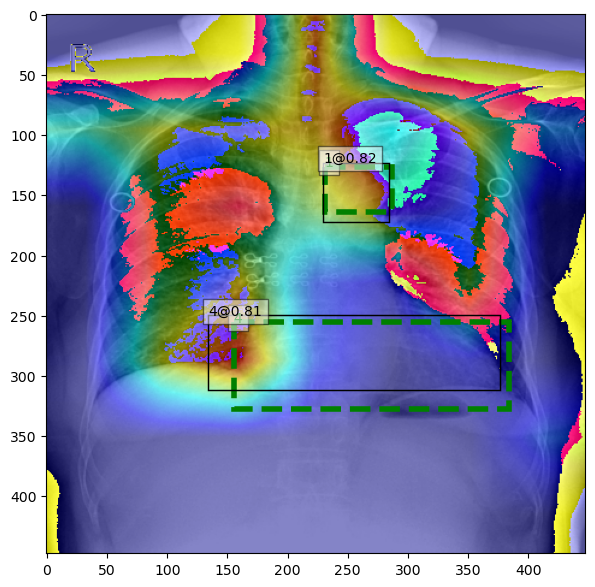

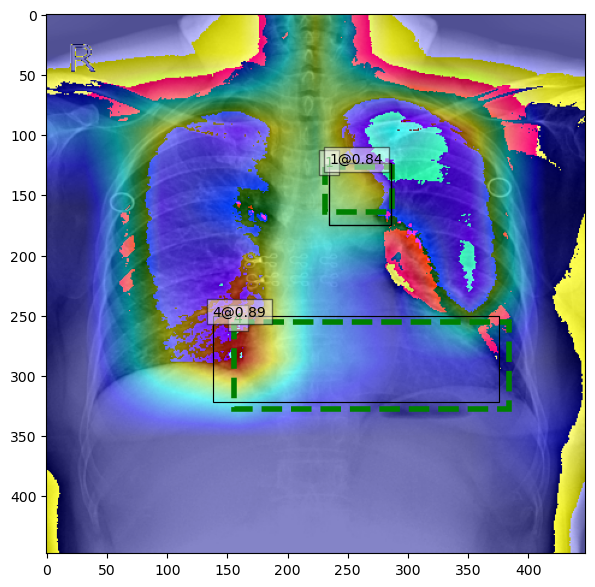

In [14]:
final_model, loss_list, map_list = train_and_evaluate(model, dataloaders["train"], dataloaders["test"], 2)

In [15]:
#best_model_path = '/kaggle/input/supplements/fasterrcnn_xrv_15epo_map30.pt'
best_model_path = './f-rcnn_xrv_resnet50_best_checkpoint.pt'
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint["model_state_dict"]) # run the huge cell before to get a global model to load the weights into
#optimizer.load_state_dict(checkpoint["optimizer_state_dict"]) # optimizer is currently in scope of train_and_eval 
epoch = checkpoint["epoch"]
loss = checkpoint["loss"]
map = checkpoint["map"]


def evaluate_and_create_csv(bestModel, inf_dataloader, device, score_thresh=0.0, img_scale=448):
    bestModel.to(device)
    bestModel.eval()
    results = []
    img_size_df = pd.read_csv("../data/amia-public-challenge-2024/img_size.csv")    
    with torch.no_grad():
        for images, image_ids in tqdm(inf_dataloader, desc="Inference", leave=True):
            images = [image.to(device) for image in images]
            preds = bestModel(images)
            
            
            '''
            plot_img_bbox(
                images[0],
                {"boxes":[]},
                {"boxes":[]},
                f"Image {filenames[idx]}",
            )
            return
            '''
            for img, image_id in zip(images, image_ids):
                og_dims = img_size_df[img_size_df['image_id'] == image_id]
                x_scale, y_scale = 1,1
                if not og_dims.empty:
                    # img_size.csv - the original dimensions of the files: dim0 is the height and dim1 is the width
                    x_scale = og_dims['dim1'] / img_scale
                    y_scale = og_dims['dim0'] / img_scale
                for pred in preds:
                    boxes = pred['boxes'].cpu().numpy()
                    labels = pred['labels'].cpu().numpy()
                    scores = pred['scores'].cpu().numpy()

                    row = [image_id]
                    #print(output)

                    if len(boxes) > 0:
                        targets = []
                        for box, label, score in zip(boxes, labels, scores):
                            
                            if score >= score_thresh:
                                # Ensure the bounding box coordinates are integers
                                box = [
                                    int(box[0] * x_scale),  # Scale xmin
                                    int(box[1] * y_scale),  # Scale ymin
                                    int(box[2] * x_scale),  # Scale xmax
                                    int(box[3] * y_scale)   # Scale ymax
                                ]
                                # switch class back to AMIA format
                                targets.append(f"{int(label)-1} {score:.2f} {int(box[0])} {int(box[1])} {int(box[2])} {int(box[3])}")
                        row.append(" ".join(targets))
                    else:
                        # no boxes -> class 14 'No finding'
                        row.append("14 1 0 0 1 1")

                    results.append(",".join(row)) # image_id, [class score box] [...]
    
    output_csv_path = 'submission.csv'
    with open(output_csv_path, 'w') as f:
        f.write("image_id,PredictionString\n") # header row
        print("Writing predictions...")
        for result in results:
            f.write(f"{result}\n")
        print("All predictions written!")
    return results


results = evaluate_and_create_csv(model, dataloaders["inference"], get_device())

Device set to cuda.


Inference:   0%|          | 0/6427 [00:00<?, ?it/s]

Writing predictions...
All predictions written!


In [16]:
import pandas as pd

def convert_tensors_to_cpu(value):
    if isinstance(value, torch.Tensor):
        return value.cpu().numpy() if value.numel() > 1 else value.cpu().item()
    elif isinstance(value, dict):
        return {k: convert_tensors_to_cpu(v) for k, v in value.items()}
    elif isinstance(value, list):
        return [convert_tensors_to_cpu(v) for v in value]
    else:
        return value

def convert_dict_tensors_to_cpu(dict_list):
    converted_list = []
    for epoch_dict in dict_list:
        converted_dict = {key: convert_tensors_to_cpu(value) for key, value in epoch_dict.items()}
        converted_list.append(converted_dict)
    return converted_list

losses_df = pd.DataFrame(convert_dict_tensors_to_cpu(loss_list))
losses_df['epoch'] = range(len(loss_list))
losses_df = losses_df[['epoch'] + [col for col in losses_df.columns if col != 'epoch']]

losses_df.to_csv("loss.csv")

converted_map_list = convert_dict_tensors_to_cpu(map_list)
map_df = pd.DataFrame(converted_map_list)

map_per_class_df = pd.DataFrame(
    [
        [
            entry['map_per_class'][i].item() if (i in entry['classes']) else None
            for i in range(len(entry['map_per_class']))
        ]
        for entry in converted_map_list
    ],
    columns=[f'{i}_map' for i in range(len(converted_map_list[0]['map_per_class']))]
)

mar_100_per_class_df = pd.DataFrame(
    [
        [
            entry['mar_100_per_class'][i].item() if (i in entry['classes']) else None
            for i in range(len(entry['mar_100_per_class']))
        ]
        for entry in converted_map_list
    ],
    columns=[f'{i}_mar' for i in range(len(converted_map_list[0]['mar_100_per_class']))]
)
map_df = pd.concat([map_df.drop(['map_per_class', 'mar_100_per_class'], axis=1), map_per_class_df, mar_100_per_class_df], axis=1)
map_df['epoch'] = range(len(map_df))
map_df = map_df[['epoch'] + [col for col in map_df.columns if col != 'epoch']]
map_df.to_csv("map.csv")

In [17]:
import altair as alt

losses_df['epoch'] = losses_df.index + 1  # Assuming index starts from 0 and represents the epochs

chart = alt.Chart(losses_df.reset_index()).transform_fold(
    fold=['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'],
    as_=['loss_type', 'loss_value']
).mark_line().encode(
    x=alt.X('epoch:N', title='Epoch'),
    y=alt.Y('loss_value:Q', title='Loss'),
    color='loss_type:N',
    tooltip=['epoch:N', 'loss_type:N', 'loss_value:Q']
).properties(
    title='Loss Components Over Epochs',
    width=600,
    height=400
).interactive()

chart

alt.Chart(...)

In [18]:
import altair as alt
import pandas as pd

# Assuming map_df is your DataFrame
map_df['epoch'] = map_df.index + 1  # Assuming index starts from 0 and represents the epochs

# Filter out the 'mar' columns, keeping only the 'map' columns
map_columns = [col for col in map_df.columns if '_map' in col and col != 'epoch']
filtered_map_df = map_df[['epoch'] + map_columns]

# Convert the DataFrame into a format suitable for plotting with Altair
map_melted_df = filtered_map_df.melt(id_vars=['epoch'], var_name='class', value_name='map_value')

# Map class numbers to class names
map_melted_df['class_name'] = map_melted_df['class'].apply(lambda x: class_names[int(x.split('_')[0])])

# Create the base chart with lines and circles
base = alt.Chart(map_melted_df).encode(
    x=alt.X('epoch:N', title='Epoch'),  # Ensure integer display
    y=alt.Y('map_value:Q', title='mAP'),
    color=alt.Color('class_name:N', legend=None),  # Remove legend as labels will be used
    tooltip=['epoch:N', 'class_name:N', 'map_value:Q']
).properties(
    width=800,
    height=400
)

lines = base.mark_line()
circles = base.mark_circle(size=60)

# Add labels at the end of the lines with class names using the simplified method
labels = alt.Chart(map_melted_df).mark_text(align='left', dx=5).encode(
    x=alt.X('epoch:N', aggregate='max'),
    y=alt.Y('map_value:Q', aggregate={'argmax': 'epoch'}),
    text=alt.Text('class_name:N'),
    color=alt.Color('class_name:N', legend=None)
)

# Combine the line chart, circles, and labels
chart = (lines + circles + labels)

# Configure the chart to disable zooming/panning
chart = chart.properties(
    title='mAP for Each Class Over Epochs'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).interactive(
    bind_x=False,
    bind_y=False
)

chart.display()


alt.LayerChart(...)

In [19]:
leaderboard = {
    'SMX_TEAM': 0.343,  # Gold
    '33': 0.328, # Silver
    'The Guiris': 0.314,  # Bronze
    'Lukassen / sample': 0.066   # Black
}

# Convert leaderboard data into a DataFrame for plotting
leaderboard_df = pd.DataFrame({
    'Position': list(leaderboard.keys()),
    'mAP': list(leaderboard.values()),
    'Color': ['gold', 'silver', 'bronze', 'black']
})

# Convert leaderboard data into a DataFrame for plotting
leaderboard_df = pd.DataFrame({
    'Position': list(leaderboard.keys()),
    'map': list(leaderboard.values()),
})

# Line chart for overall mAP
map_line = alt.Chart(map_df).mark_line(point=True).encode(
    x=alt.X('epoch:O', title='Epoch'),
    y=alt.Y('map:Q', title='mAP'),
    tooltip=['epoch:O', 'mAP:Q']
).properties(
    width=600,
    height=400,
    title="Overall mAP Over Time"
)

# Horizontal lines for leaderboard positions
leaderboard_lines = alt.Chart(leaderboard_df).mark_rule().encode(
    y='map:Q',
    color=alt.Color('Position:N', scale=alt.Scale(
        domain=['SMX_TEAM', '33', 'The Guiris', 'Lukassen / sample'], 
        range=['gold', 'silver', 'brown', 'gray']
    )),
    size=alt.value(2),  # Thicker line
    tooltip=['Position:N', 'map:Q']
)

leaderboard_text = alt.Chart(leaderboard_df).mark_text(
    align='right',
    baseline='middle',
    dx=20,
    dy=8
).encode(
    y='map:Q',
    text='Position:N',
    color=alt.Color('Position:N', scale=alt.Scale(
        domain=['SMX_TEAM', '33', 'The Guiris', 'Lukassen / sample'], 
        range=['gold', 'silver', 'bronze', 'black']
    ))
)

# Combine the line chart, horizontal lines, and text labels
final_chart = map_line + leaderboard_lines + leaderboard_text

# Display the chart
final_chart.display()

alt.LayerChart(...)

In [ ]:
torch.save(model,'fasterrcnn_after_training.pt')
